In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
from mppi import InputFiles as I, Calculators as C, Datasets as D, Parsers as P, Utilities as U
from mppi.Calculators import Tools
from mppi.Datasets import PostProcessing as PP
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
# RunRules for local computations
mpi = 4
omp = 2

rr = C.RunRules(omp_num_threads=omp,mpi=mpi)
code = C.QeCalculator(rr)
#code.global_options()

In [3]:
# RunRules for ismhpc
# The product of ntasks_per_node*cpus_per_task is equal to 32. 
# Many mpi are needed for better performances
nodes = 1
ntasks_per_node = 32 #16
cpus_per_task = 1 #2
omp_num_threads = 1 #2

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='all12h', #'all12h',
                memory='125000',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,
                omp_num_threads=omp_num_threads)
code = C.YamboCalculator(rr,activate_BeeOND=True) #,reformat=False,clean_restart=False,skip=False,fatlog=True)
code.global_options()

Initialize a Yambo calculator with scheduler slurm


{'scheduler': 'slurm',
 'nodes': 1,
 'ntasks_per_node': 32,
 'cpus_per_task': 1,
 'omp_num_threads': 1,
 'gpus_per_node': None,
 'memory': '125000',
 'time': None,
 'partition': 'all12h',
 'account': None,
 'qos': None,
 'map_by': None,
 'pe': 1,
 'rank_by': None,
 'executable': 'yambo',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'activate_BeeOND': True,
 'verbose': True,
 'fatlog': False}

In [ ]:
# RunRules for m100
nodes = 32 # 16
ntasks_per_node = 4
cpus_per_task=32
omp_num_threads=8
gpus_per_node=4
pe=8

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='m100_usr_prod',
                account='IscrC_PhoGra',qos='m100_qos_bprod',
                memory='230GB',time='23:59:00',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,omp_num_threads=omp_num_threads,
                gpus_per_node=gpus_per_node,pe=pe,
                map_by='socket',rank_by='core')
code = C.YamboCalculator(rr) #,reformat=False
code.global_options()

# BSE analysis for monolayer MoS$_2$

We compute the absorption spectrum of the monolayer MoS$_2$ within the BSE framework.

We make usage of the convergence analysis and of the ndb databases created in the GW runlevel

First we build and init the run directories and perform link off the ndb database computed
in the GW analysis

In [6]:
kpoints = [18,30,42]

for k in kpoints:
    source_dir = 'DFT_analysis/kpoints_%s-nbnds_250.save'%k
    run_dir = 'BSE_analysis/kpoints_%s-nbnds_250'%k
    Tools.init_yambo_run_dir(Tools.make_p2y(source_dir),run_dir=run_dir)

SAVE folder DFT_analysis/kpoints_18-nbnds_250.save/SAVE already present. No operations performed.
SAVE folder already present in BSE_analysis/kpoints_18-nbnds_250. No operations performed.
SAVE folder DFT_analysis/kpoints_30-nbnds_250.save/SAVE already present. No operations performed.
SAVE folder already present in BSE_analysis/kpoints_30-nbnds_250. No operations performed.
SAVE folder DFT_analysis/kpoints_42-nbnds_250.save/SAVE already present. No operations performed.
SAVE folder already present in BSE_analysis/kpoints_42-nbnds_250. No operations performed.


We create a link of the folders with the ndb database created in the _GW_analysis_ in the _BSE_analysis_ folder

In [7]:
def find_ndbs(path):
    ndbs =  []
    files = os.listdir(path)
    for f in files:
        if 'ndb_' in f : ndbs.append(os.path.abspath(os.path.join(path,f)))
    return ndbs

def make_link(ndbs,dest):
    abs_dest = os.path.abspath(dest)
    for ndb in ndbs:
        ndb_name = ndb.split('/')[-1]
        target = os.path.join(abs_dest,ndb_name)
        if not os.path.isdir(target):
            print(ndb,target)
            os.symlink(ndb,target,target_is_directory=True)

In [8]:
for k in kpoints:
    ndbs = find_ndbs('GW_analysis/kpoints_%s-nbnds_250/'%k)
    make_link(ndbs,'BSE_analysis/kpoints_%s-nbnds_250/'%k)

/work/dalessandro/2D_ELECTRONIC_OPTICAL_PROPERTIES/MoS2/GW_analysis/kpoints_18-nbnds_250/ndb_em1d-ngsblkxp_6.0-bndsrnxp_250 /work/dalessandro/2D_ELECTRONIC_OPTICAL_PROPERTIES/MoS2/BSE_analysis/kpoints_18-nbnds_250/ndb_em1d-ngsblkxp_6.0-bndsrnxp_250


## BSE convergence analysis for the low energy excitations

We test the optimal BSE parameters by constructing the absorption spectrum in the low
energy range. In this way we analyze the effects of the relevant parameters of a BSE calculation
and we study the convergence w.r.t to the $k$-points sampling.

The analysis is performed on-top of the DFT computations using a scissor to reproduce the 
experimental gap

In [6]:
dft_gap = 1.78
exp_gap = 2.4 # value to be checked
scissor = exp_gap-dft_gap # eV
print('scissor',scissor)
kpoints = [18,30,42]

scissor 0.6199999999999999


First we test the convergence of the spectrum w.r.t to number of bands used in the BSE calculations.

We perform this analysis in the 18x18x1 grid without the rim_w

In [39]:
k = kpoints[0]
run_dir = 'BSE_analysis/kpoints_%s-nbnds_250/'%k

RandGvec = 100
Randqpts = 5e6
RandGvecW = 10
NGsBlkXs = 6.0 # Ha G size of the response function
EXXRLvcs = 30. # Ha use this value for the BSENGexx variable
BndsRnXs = [1,250] # Polarization function bands
FFTGvecs = 40. # Ha 
elec_field = [1.,0.,0.]
BSEBands = [[25,28],[25,30],[23,30]]
energy_range = [0,4] # eV
energy_step = 1000
damping = [0.05,0.05] # eV

study = D.Dataset(num_tasks=1,verbose=True,skip=True)
study.set_postprocessing_function(PP.yambo_parse_data)

inp = I.YamboInput('yambo -r -o b -k sex -y d',folder=run_dir)
inp.set_scalar_variables(CUTGeo='slab z')
inp.set_array_variables(RandQpts=Randqpts)
inp.set_array_variables(units='RL',RandGvec=RandGvec,RandGvecW=RandGvecW)
inp.set_array_variables(units='Ha',BSENGexx=EXXRLvcs,BSENGBlk=NGsBlkXs,FFTGvecs=FFTGvecs)
inp.set_array_variables(BndsRnXs=BndsRnXs,BLongDir=elec_field,KfnQP_E=[scissor,1.,1.])
inp.set_array_variables(units='eV',BEnRange=energy_range,BDmRange=damping)
inp.set_array_variables(BEnSteps=energy_step)
inp.set_scalar_variables(BS_CPU='32.1.1',BS_ROLEs= 'k.eh.t')     

for bsebands in BSEBands:
    inp.set_array_variables(BSEBands=bsebands)
    idd = 'bse-bsebands_%s-%s_norimw'%(bsebands[0],bsebands[1])
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
                 jobname=[idd,',ndb_em1d-ngsblkxp_6.0-bndsrnxp_250','ndb_rim_cutoff','ndb_dipoles-bnds_250'],reformat=True)

Initialize a Dataset with 1 parallel tasks


In [57]:
#study.runs[1]

In [41]:
results = study.run()

Run the selection [0, 1, 2] with the parallel task_groups [[0], [1], [2]] 

Run the task [0] 
Skip the run of bse-bsebands_25-28_norimw
Task [0] ended 
 
Run the task [1] 
run command: mpirun -np 32 yambo -F bse-bsebands_25-30_norimw.in -J "bse-bsebands_25-30_norimw,,ndb_em1d-ngsblkxp_6.0-bndsrnxp_250,ndb_rim_cutoff,ndb_dipoles-bnds_250" -C bse-bsebands_25-30_norimw
slurm submit:  cd BSE_analysis/kpoints_18-nbnds_250/ ; sbatch job_bse-bsebands_25-30_norimw.sh
computation bse-bsebands_25-30_norimw is running...
computation bse-bsebands_25-30_norimw ended
Run performed in 06m-06s
Task [1] ended 
 
Run the task [2] 
Skip the run of bse-bsebands_23-30_norimw
Task [2] ended 
 


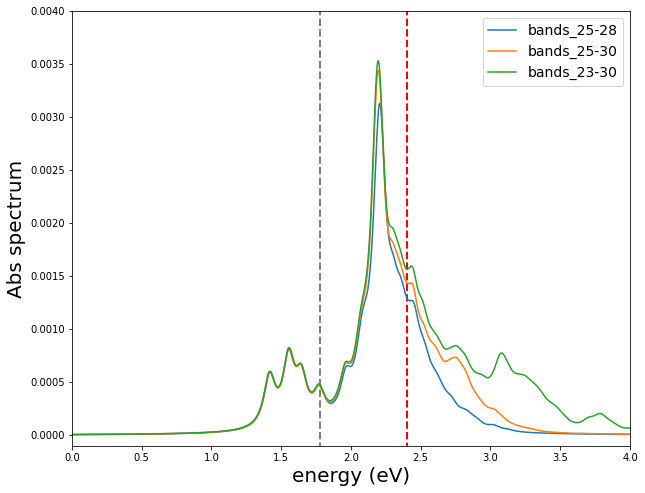

In [42]:
fig, ax = plt.subplots(figsize=(10, 8))

for ind,b in enumerate(BSEBands):
    data = results[ind].data['eps_q1_diago_bse']
    energy = data['energy']
    eps_im = data['eps_imag']
    ax.plot(energy,eps_im,label='bands_%s-%s'%(b[0],b[1])) 
ax.vlines(dft_gap,-1,10,linestyles='--',color='gray',linewidth=2)
ax.vlines(exp_gap,-1,10,linestyles='--',color='red',linewidth=2)
ax.set_xlim(0,4)
ax.set_ylim(-1e-4,4e-3)
ax.set_ylabel('Abs spectrum',size=20)
ax.set_xlabel('energy (eV)',size=20)
ax.legend(fontsize=14)

Next we test the convergence w.r.t to $k$-points samplings

In [52]:
RandGvec = 100
Randqpts = 5e6
RandGvecW = 10
NGsBlkXs = 6.0 # Ha G size of the response function
EXXRLvcs = 30. # Ha use this value for the BSENGexx variable
BndsRnXs = [1,250] # Polarization function bands
FFTGvecs = 40. # Ha 
elec_field = [1.,0.,0.]
BSEBands = [25,30]
energy_range = [0,4] # eV
energy_step = 1000
damping = [0.05,0.05] # eV

study = D.Dataset(num_tasks=2,verbose=True,skip=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for k in kpoints:
    run_dir = 'BSE_analysis/kpoints_%s-nbnds_250/'%k
    inp = I.YamboInput('yambo -r -o b -k sex -y d',folder=run_dir)
    inp.set_scalar_variables(CUTGeo='slab z')
    inp.set_array_variables(RandQpts=Randqpts)
    inp.set_array_variables(units='RL',RandGvec=RandGvec,RandGvecW=RandGvecW)
    inp.set_array_variables(units='Ha',BSENGexx=EXXRLvcs,BSENGBlk=NGsBlkXs,FFTGvecs=FFTGvecs)
    inp.set_array_variables(BLongDir=elec_field,KfnQP_E=[scissor,1.,1.])
    inp.set_array_variables(BSEBands=BSEBands)
    inp.set_array_variables(units='eV',BEnRange=energy_range,BDmRange=damping)
    inp.set_array_variables(BEnSteps=energy_step)
    inp.set_scalar_variables(BS_CPU='32.1.1',BS_ROLEs= 'k.eh.t')     
    idd = 'bse-bsebands_%s-%s-kpoints_%s_norimw'%(BSEBands[0],BSEBands[1],k)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
                 jobname=[idd,',ndb_em1d-ngsblkxp_6.0-bndsrnxp_250','ndb_rim_cutoff','ndb_dipoles-bnds_250'],reformat=True)

Initialize a Dataset with 2 parallel tasks


In [56]:
#study.runs[2]

In [54]:
results = study.run()

Run the selection [0, 1, 2] with the parallel task_groups [[0, 1], [2]] 

Run the task [0, 1] 
Skip the run of bse-bsebands_25-30-kpoints_18_norimw
Skip the run of bse-bsebands_25-30-kpoints_30_norimw
Task [0, 1] ended 
 
Run the task [2] 
Skip the run of bse-bsebands_25-30-kpoints_42_norimw
Task [2] ended 
 


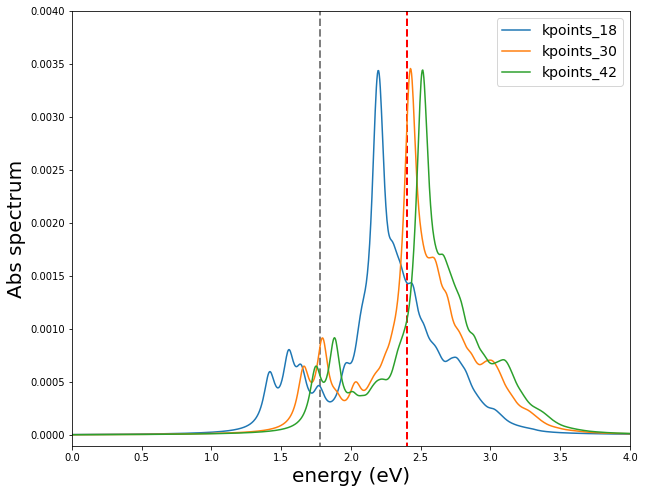

In [55]:
fig, ax = plt.subplots(figsize=(10, 8))

for ind,k in enumerate(kpoints):
    data = results[ind].data['eps_q1_diago_bse']
    energy = data['energy']
    eps_im = data['eps_imag']
    ax.plot(energy,eps_im,label='kpoints_%s'%k) 
ax.vlines(dft_gap,-1,10,linestyles='--',color='gray',linewidth=2)
ax.vlines(exp_gap,-1,10,linestyles='--',color='red',linewidth=2)
ax.set_xlim(0,4)
ax.set_ylim(-1e-4,4e-3)
ax.set_ylabel('Abs spectrum',size=20)
ax.set_xlabel('energy (eV)',size=20)
ax.legend(fontsize=14)

We repeat the $k$-points convergence using the rim_w option

In [62]:
RandGvec = 100
Randqpts = 5e6
RandGvecW = 10
NGsBlkXs = 6.0 # Ha G size of the response function
EXXRLvcs = 30. # Ha use this value for the BSENGexx variable
BndsRnXs = [1,250] # Polarization function bands
FFTGvecs = 40. # Ha 
elec_field = [1.,0.,0.]
BSEBands = [25,30]
energy_range = [0,4] # eV
energy_step = 1000
damping = [0.05,0.05] # eV

study = D.Dataset(num_tasks=2,verbose=True,skip=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for k in kpoints:
    run_dir = 'BSE_analysis/kpoints_%s-nbnds_250/'%k
    inp = I.YamboInput('yambo -r -o b -k sex -y d',folder=run_dir)
    inp.activate_RIM_W()   
    inp.set_scalar_variables(CUTGeo='slab z')
    inp.set_array_variables(RandQpts=Randqpts)
    inp.set_array_variables(units='RL',RandGvec=RandGvec,RandGvecW=RandGvecW)
    inp.set_array_variables(units='Ha',BSENGexx=EXXRLvcs,BSENGBlk=NGsBlkXs,FFTGvecs=FFTGvecs)
    inp.set_array_variables(BLongDir=elec_field,KfnQP_E=[scissor,1.,1.])
    inp.set_array_variables(BSEBands=BSEBands)
    inp.set_array_variables(units='eV',BEnRange=energy_range,BDmRange=damping)
    inp.set_array_variables(BEnSteps=energy_step)
    inp.set_scalar_variables(BS_CPU='32.1.1',BS_ROLEs= 'k.eh.t')     
    idd = 'bse-bsebands_%s-%s-kpoints_%s_rimw'%(BSEBands[0],BSEBands[1],k)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
                 jobname=[idd,',ndb_em1d-ngsblkxp_6.0-bndsrnxp_250','ndb_rim_cutoff','ndb_dipoles-bnds_250'],reformat=False)

Initialize a Dataset with 2 parallel tasks


In [69]:
#study.runs[0]

In [65]:
results = study.run()

Run the selection [0, 1, 2] with the parallel task_groups [[0, 1], [2]] 

Run the task [0, 1] 
Skip the run of bse-bsebands_25-30-kpoints_18_rimw
Skip the run of bse-bsebands_25-30-kpoints_30_rimw
Task [0, 1] ended 
 
Run the task [2] 
Skip the run of bse-bsebands_25-30-kpoints_42_rimw
Task [2] ended 
 


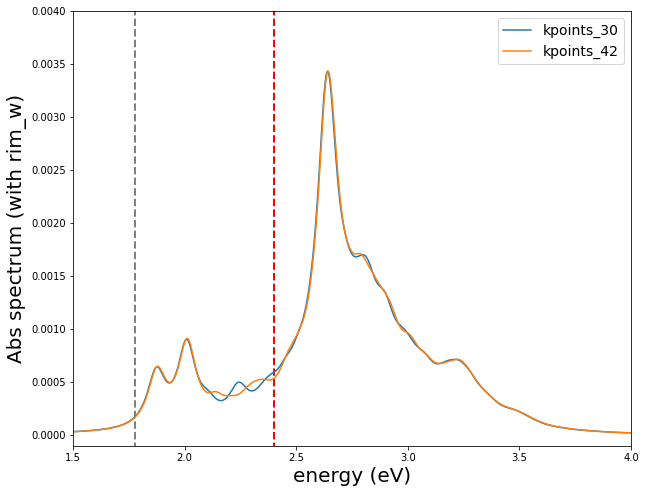

In [82]:
fig, ax = plt.subplots(figsize=(10, 8))

#for ind,k in enumerate(kpoints):
for ind in [1,2]:
    data = results[ind].data['eps_q1_diago_bse']
    energy = data['energy']
    eps_im = data['eps_imag']
    ax.plot(energy,eps_im,label='kpoints_%s'%kpoints[ind]) 
ax.vlines(dft_gap,-1,10,linestyles='--',color='gray',linewidth=2)
ax.vlines(exp_gap,-1,10,linestyles='--',color='red',linewidth=2)
ax.set_xlim(1.5,4)
ax.set_ylim(-1e-4,4e-3)
ax.set_ylabel('Abs spectrum (with rim_w)',size=20)
ax.set_xlabel('energy (eV)',size=20)
ax.legend(fontsize=14)

We observe that the rim_w improves the convergence even at the BSE level. Within this option the 30x30x1
result is very similar to the 42x42x1, apart from small ripples after the first two peaks

Before going ahead with further investigations we can check if it is possible to improve the efficiency of the computation
by adjusting some parameters (and/or by using the haydock solver instead of the diagonalization). We perform this analysis
in 30x30x1 sampling. 

In [7]:
k = 30
run_dir = 'BSE_analysis/kpoints_%s-nbnds_250/'%k

RandGvec = 100
Randqpts = 5e6
RandGvecW = 10
BSENGBlk = 3.0 # Ha  value of the BSENGBlk variable (reduced w.r.t the NGsBlkXs!)
EXXRLvcs = 30. # Ha use this value for the BSENGexx variable
BndsRnXs = [1,250] # Polarization function bands
FFTGvecs = 30. # Ha 
elec_field = [1.,0.,0.]
BSEBands = [25,30]
energy_range = [0,4] # eV
energy_step = 1000
damping = [0.05,0.05] # eV

study = D.Dataset(num_tasks=1,verbose=True,skip=False)
study.set_postprocessing_function(PP.yambo_parse_data)

 
inp = I.YamboInput('yambo -r -o b -k sex -y h',folder=run_dir)
inp.activate_RIM_W()   
inp.set_scalar_variables(CUTGeo='slab z')
inp.set_array_variables(RandQpts=Randqpts)
inp.set_array_variables(units='RL',RandGvec=RandGvec,RandGvecW=RandGvecW)
inp.set_array_variables(units='Ha',BSENGexx=EXXRLvcs,BSENGBlk=BSENGBlk,FFTGvecs=FFTGvecs)
inp.set_array_variables(BLongDir=elec_field,KfnQP_E=[scissor,1.,1.])
inp.set_array_variables(BSEBands=BSEBands)
inp.set_array_variables(units='eV',BEnRange=energy_range,BDmRange=damping)
inp.set_array_variables(BEnSteps=energy_step)
inp.set_scalar_variables(BS_CPU='32.1.1',BS_ROLEs= 'k.eh.t')     
idd = 'bse-bsebands_%s-%s-kpoints_%s_rimw-test'%(BSEBands[0],BSEBands[1],k)
study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
    jobname=[idd,',ndb_em1d-ngsblkxp_6.0-bndsrnxp_250','ndb_rim_cutoff','ndb_dipoles-bnds_250'],reformat=False)

Initialize a Dataset with 1 parallel tasks


In [8]:
#study.runs[0]

In [9]:
results = study.run()

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
delete job_out script: BSE_analysis/kpoints_30-nbnds_250/job_bse-bsebands_25-30-kpoints_30_rimw-test.out
delete folder: BSE_analysis/kpoints_30-nbnds_250/bse-bsebands_25-30-kpoints_30_rimw-test
run command: mpirun -np 32 yambo -F bse-bsebands_25-30-kpoints_30_rimw-test.in -J "bse-bsebands_25-30-kpoints_30_rimw-test,,ndb_em1d-ngsblkxp_6.0-bndsrnxp_250,ndb_rim_cutoff,ndb_dipoles-bnds_250" -C bse-bsebands_25-30-kpoints_30_rimw-test
slurm submit:  cd BSE_analysis/kpoints_30-nbnds_250/ ; sbatch job_bse-bsebands_25-30-kpoints_30_rimw-test.sh
computation bse-bsebands_25-30-kpoints_30_rimw-test is running...
computation bse-bsebands_25-30-kpoints_30_rimw-test ended
Run performed in 04m-23s
Task [0] ended 
 


In [10]:
data_ref = P.YamboOutputParser.from_file('BSE_analysis/kpoints_30-nbnds_250/bse-bsebands_25-30-kpoints_30_rimw/o-bse-bsebands_25-30-kpoints_30_rimw.eps_q1_diago_bse')
energy_ref = data_ref['eps_q1_diago_bse']['energy']
eps_im_ref = data_ref['eps_q1_diago_bse']['eps_imag']

Parse file BSE_analysis/kpoints_30-nbnds_250/bse-bsebands_25-30-kpoints_30_rimw/o-bse-bsebands_25-30-kpoints_30_rimw.eps_q1_diago_bse


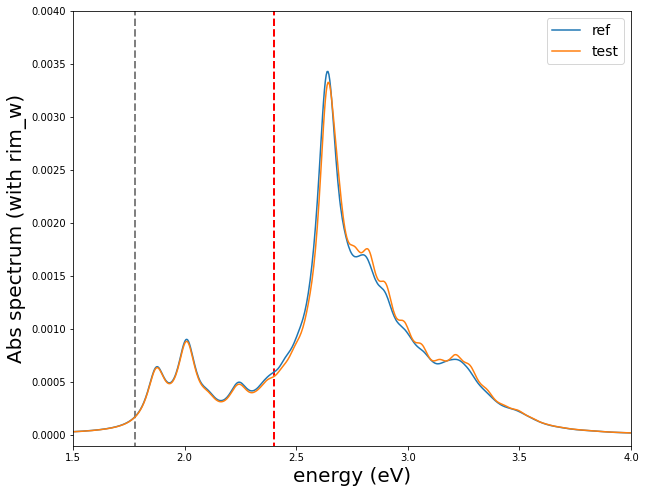

In [11]:
fig, ax = plt.subplots(figsize=(10, 8))

data = results[0].data['eps_q1_haydock_bse']
energy = data['energy']
eps_im = data['eps_imag']
ax.plot(energy_ref,eps_im_ref,label='ref') 
ax.plot(energy,eps_im,label='test') 
ax.vlines(dft_gap,-1,10,linestyles='--',color='gray',linewidth=2)
ax.vlines(exp_gap,-1,10,linestyles='--',color='red',linewidth=2)
ax.set_xlim(1.5,4)
ax.set_ylim(-1e-4,4e-3)
ax.set_ylabel('Abs spectrum (with rim_w)',size=20)
ax.set_xlabel('energy (eV)',size=20)
ax.legend(fontsize=14)

On the basis of this analysis we observe that
* The Haydock solver improved the efficiency of the evaluation of the spectrum and provides results identical to the direct diagonalization
* reducing the BSENGBlk w.r.t the size of the em1s reduces the time needed to build the BSE kernel. For instance BSENGBlk = 4.0 Ha provides
  indentical results w.r.t. the reference and also BSENGBlk = 3.0 Ha provides reliable results with minimal differences.

Using the improved parameters we test the influence of adding more bands in the abs spectrum

In [127]:
k = 30
run_dir = 'BSE_analysis/kpoints_%s-nbnds_250/'%k

RandGvec = 100
Randqpts = 5e6
RandGvecW = 10
BSENGBlk = 4.0 # Ha value of BSENGBlk (reduced w.r.t the NGBlkXs value)
EXXRLvcs = 30. # Ha use this value for the BSENGexx variable
BndsRnXs = [1,250] # Polarization function bands
FFTGvecs = 30. # Ha 
elec_field = [1.,0.,0.]
BSEBands = [[23,30],[21,32],[19,34]]
energy_range = [0,4] # eV
energy_step = 1000
damping = [0.05,0.05] # eV

study = D.Dataset(num_tasks=3,verbose=True,skip=True)
study.set_postprocessing_function(PP.yambo_parse_data)

inp = I.YamboInput('yambo -r -o b -k sex -y h',folder=run_dir)
inp.activate_RIM_W()   
inp.set_scalar_variables(CUTGeo='slab z')
inp.set_array_variables(RandQpts=Randqpts)
inp.set_array_variables(units='RL',RandGvec=RandGvec,RandGvecW=RandGvecW)
inp.set_array_variables(units='Ha',BSENGexx=EXXRLvcs,BSENGBlk=BSENGBlk,FFTGvecs=FFTGvecs)
inp.set_array_variables(BLongDir=elec_field,KfnQP_E=[scissor,1.,1.])
inp.set_array_variables(units='eV',BEnRange=energy_range,BDmRange=damping)
inp.set_array_variables(BEnSteps=energy_step)
inp.set_scalar_variables(BS_CPU='32.1.1',BS_ROLEs= 'k.eh.t')     
for bsebands in BSEBands:
    inp.set_array_variables(BSEBands=bsebands)
    idd = 'bse-bsebands_%s-%s-kpoints_%s_rimw'%(bsebands[0],bsebands[1],k)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
        jobname=[idd,',ndb_em1d-ngsblkxp_6.0-bndsrnxp_250','ndb_rim_cutoff','ndb_dipoles-bnds_250'],reformat=False)

Initialize a Dataset with 3 parallel tasks


In [133]:
#study.runs[0]

In [135]:
results = study.run()

Run the selection [0, 1, 2] with the parallel task_groups [[0, 1, 2]] 

Run the task [0, 1, 2] 
Skip the run of bse-bsebands_23-30-kpoints_30_rimwSkip the run of
 bse-bsebands_21-32-kpoints_30_rimw
Skip the run of bse-bsebands_19-34-kpoints_30_rimw
Task [0, 1, 2] ended 
 


In [136]:
data_ref = P.YamboOutputParser.from_file('BSE_analysis/kpoints_30-nbnds_250/bse-bsebands_25-30-kpoints_30_rimw/o-bse-bsebands_25-30-kpoints_30_rimw.eps_q1_diago_bse')
energy_ref = data_ref['eps_q1_diago_bse']['energy']
eps_im_ref = data_ref['eps_q1_diago_bse']['eps_imag']

Parse file BSE_analysis/kpoints_30-nbnds_250/bse-bsebands_25-30-kpoints_30_rimw/o-bse-bsebands_25-30-kpoints_30_rimw.eps_q1_diago_bse


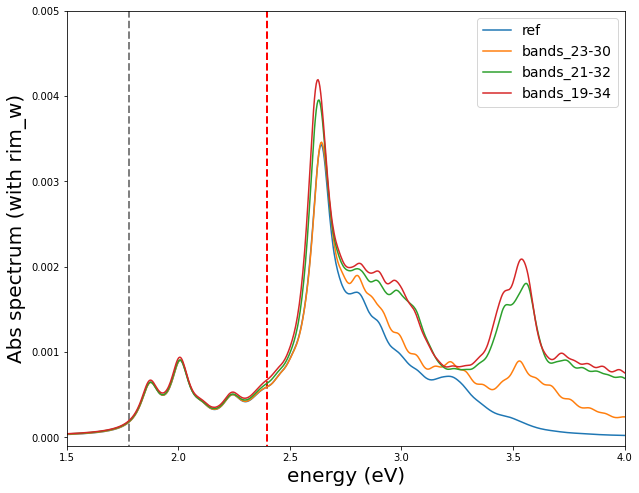

In [139]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(energy_ref,eps_im_ref,label='ref')
for ind,b in enumerate(BSEBands):
    data = results[ind].data['eps_q1_haydock_bse']
    energy = data['energy']
    eps_im = data['eps_imag']
    ax.plot(energy,eps_im,label='bands_%s-%s'%(b[0],b[1])) 
ax.vlines(dft_gap,-1,10,linestyles='--',color='gray',linewidth=2)
ax.vlines(exp_gap,-1,10,linestyles='--',color='red',linewidth=2)
ax.set_xlim(1.5,4)
ax.set_ylim(-1e-4,5e-3)
ax.set_ylabel('Abs spectrum (with rim_w)',size=20)
ax.set_xlabel('energy (eV)',size=20)
ax.legend(fontsize=14)

In [ ]:
###########################################################

optics                       # [R OPT] Optics
rim_cut                      # [R RIM CUT] Coulomb potential
bss                          # [R BSS] Bethe Salpeter Equation solver
em1s                         # [R Xs] Static Inverse Dielectric Matrix
bse                          # [R BSE] Bethe Salpeter Equation.
bsk                          # [R BSK] Bethe Salpeter Equation kernel
Lkind="Lbar"
StdoHash=  40                # [IO] Live-timing Hashes
# Overall cutoff
FFTGvecs = 60 Ry             # [FFT] Plane-waves
# RIM settings
RandQpts=1000000             # [RIM] Number of random q-points in the BZ
RandGvec= 1            RL    # [RIM] Coulomb interaction RS components
CUTGeo= "box z"               # [CUT] Coulomb Cutoff geometry: box/cylinder/sphere X/Y/Z/XY..
% CUTBox
 0.00     | 0.00     | 38.00     |        # [CUT] [au] Box sides
%
# BSE
BS_CPU= "64.1.1"                   # [PARALLEL] CPUs for each role
BS_ROLEs= "k.eh.t"                 # [PARALLEL] CPUs roles (k,eh,t)
BS_nCPU_diago=64              # [PARALLEL] CPUs for matrix diagonalization
BSEmod= "causal"             # [BSE] resonant/causal/coupling
BSKmod= "SEX"                # [BSE] IP/Hartree/HF/ALDA/SEX/BSfxc
BSSmod= "d"                  # [BSS] (h)aydock/(d)iagonalization/(i)nversion/(t)ddft`
BSENGexx=  40          Ry    # [BSK] Exchange components
ALLGexx                      # [BSS] Force the use use all RL vectors for the exchange part
BSENGBlk=  8           Ry    # [BSK] Screened interaction block size
% KfnQP_E
 1.000000 | 1.000000 | 1.000000 |        # [EXTQP BSK BSS] E parameters  (c/v) eV|adim|adim
%
% BEnRange
  0.00000 |  4.00000 | eV    # [BSS] Energy range
%
% BDmRange
  0.05000 |  0.05000 | eV    # [BSS] Damping range
%
BEnSteps= 2000               # [BSS] Energy steps
% BLongDir
 1.000000 | 0.000000 | 0.000000 |        # [BSS] [cc] Electric Field
%
% BSEQptR
 119 | 119 |                     # [BSK] Transferred momenta range
%
% BSEBands
   25 |  28 |                 # [BSK] Bands range
%
% BSehWind
 100.0000 | 100.0000 |       # [BSK] [o/o] E/h coupling pairs energy window
%
WRbsWF                      # [BSS] Write to disk excitonic the FWs
# Static screening
X_and_IO_CPU= "1 1 16 2 1"       # [PARALLEL] CPUs for each role
X_and_IO_ROLEs= "q g k c v"      # [PARALLEL] CPUs roles (q,g,k,c,v)
X_and_IO_nCPU_LinAlg_INV=-1      # [PARALLEL] CPUs for Linear Algebra (if -1 it is automatically set)
Chimod= "hartree"            # [X] IP/Hartree/ALDA/LRC/BSfxc
% QpntsRXs
   1 | 147 |                 # [Xs] Transferred momenta
%
% BndsRnXs
   1 |  200 |                 # [Xs] Polarization function bands
%
NGsBlkXs= 8            Ry    # [Xs] Response block size
